In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline
from scipy.stats import entropy 
from scipy.stats import chisquare
from scipy.stats import ttest_ind


In [37]:
popular_color_features = "../Final_features/vine_features_ordered.csv"
unpopular_color_features = "../Final_features/Unpopular2016_aesthetic_ordered.csv"
aesthetic_color_features = "../Logs/aesthetic_features_6.csv"
#aesthetic_csv = "../Final_features/total_aesthetic_thirds.pk"
aesthetic_csv = "../Final_features/Thirds_aesthetic_thirds.pk"
aesthetic_pop_temporal = "../Final_features/popTemporalSampledAesthetic.csv"
aesthetic_unpop_temporal = "../Final_features/unpopTemporalSampledAesthetic.csv"

#instaAesthetic = "../Final_features/instaSamplesSorted.csv"
instaAesthetic = "../Final_features/sortedInstaFeats.csv"

In [51]:
def readFeatureFile(color_features):
    with open(color_features) as g:
        featureLines = g.readlines()
    print len(featureLines)
    return featureLines

def readAesFeatuers(lines):
    features = []
    for line in lines:
        components = line.strip().split('|')
        features.append([float(x) for x in components[1:]])
    return features

def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            #median = np.median(feats,0)
            median = feats[0]
            for i in range(len(median)):
                if np.isnan(median[i]):
                    median[i] = 0.0
            features.append(median)
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

def readFeaturesAsVector(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            features.append(feats)
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids

def readInstaFeaturesAsVector(lines):
    ids = []
    features = []
    feats = dict()
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('+')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('+')[0]
        sequence = components[0].strip().split('+')[1].split('.')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            f = []
            #print feats
            for i in range(1,len(feats.keys())+1):
                try:
                    f.append(feats[str(i)])
                except KeyError:
                    print len(feats.keys()) , i
            features.append(f)
            feats.clear()
            feats[sequence] = [float(x) for x in components[1:]]
            #feats.append([float(x) for x in components[1:]])
        else :
            feats[sequence] = [float(x) for x in components[1:]]
            #feats.append([float(x) for x in components[1:]]) 
            
    return features, ids

def getMaximumHistogram(featureVec , dimension ,function):
    classifierCoeefs = np.asarray([ 0.       ,   0.03343475,  0.0218128 ,  0.02341605 , 0.02355142,  0.02526042,
  0.02290093,  0.02206709,  0.02891414,  0.02192985,  0.01503583,  0.,
  0.02182189,  0.02630779 , 0.02273517,  0.02183237,  0.02532157,  0.02034298,
  0.01239432])
    
    maxClassifierCoefs = np.asarray([[ 0.       ,   0.03453842,  0.02570736,  0.02543318,  0.02516512,  0.02729427,
  0.02423508,  0.02827428,  0.02917423,  0.02597833,  0.01458388,  0.,
  0.02122234,  0.02544339,  0.02607218,  0.02100649,  0.02610868,  0.02172767,
  0.01354962]])
    max_hist = np.zeros(7)
    for video in featureVec:
        vec = [np.dot(maxClassifierCoefs,video[i][:]) for i in range(len(video))]
        maxArg = function(np.asarray(vec))
        max_hist[maxArg]+=1
    return [np.sum(max_hist[:2])/len(featureVec) , np.sum(max_hist[2:4])/len(featureVec) , np.sum(max_hist[4:6])/len(featureVec) ]

def getMaximumHistInsta(features, function):
    maxClassifierCoefs = np.asarray([[ 0.       ,   0.03453842,  0.02570736,  0.02543318,  0.02516512,  0.02729427,
    0.02423508,  0.02827428,  0.02917423,  0.02597833,  0.01458388,  0.,
    0.02122234,  0.02544339,  0.02607218,  0.02100649,  0.02610868,  0.02172767,
    0.01354962]])
    max_hist = np.zeros(3)
    for video in features:
        if len(video) < 1:
            continue
        vec = [np.median(video[i][:]) for i in range(len(video))]
        maxArg = function(np.asarray(vec))
        thirds = (len(video)/3) + 1
        max_hist[int(maxArg/thirds)]+=1
    return max_hist
    

In [39]:
poptempLines = readFeatureFile(popular_color_features)



50187


In [40]:
unpoptempLines = readFeatureFile(aesthetic_unpop_temporal)

1210


In [41]:
instaLines = readFeatureFile(instaAesthetic)

35366


In [42]:
instaFeatureVec , instaPosts = readInstaFeaturesAsVector(instaLines)

2 1
3 2
3 3
2 1
4 4
4 2
4 4
4 2
3 3
5 4
4 2
4 4
4 1
4 3
9 6
8 5
8 7
11 4
11 5
3 1
3 3
4 3
4 2
4 3
4 2
9 4
3 1
3 3
11 5
3 2
10 7
10 8
10 9
2 2
7 2
7 6
7 7
5 2
5 1
5 4
12 6
12 9
7 3
7 4
7 7
4 2
4 3
5 4
4 2
4 3
4 2
6 3
6 4
6 5
3 1
3 2
3 3
5 2
6 3
6 1
6 2
6 5
2 1
4 1
5 4
4 3
4 4
3 1
3 2
2 1
2 2
8 3
8 4
8 5
8 7
4 1
4 2
5 3
5 5
4 2
9 3
9 4
9 6
9 8
4 2
5 4
5 4
9 1
9 2
9 5
9 7
5 3
5 4
4 1
2 2
7 2
7 3
7 4
7 6
7 1
12 2
12 5
4 2
4 2
4 3
5 1
5 5
4 3
5 4
2 1
2 2
5 3
6 3
6 4
4 1
4 2
3 2
3 3
7 6
7 7
5 3
4 2
4 1
4 3
4 3
3 2
4 1
5 2
3 1
3 2
3 3
4 1
4 3
4 1
5 3
5 1
11 4
11 8
11 11
6 2
6 4
5 5
4 1
4 4
4 3
4 4
4 1
8 2
8 4
8 5
8 6
3 2
3 3
5 4
8 2
8 6
8 8
10 3
10 5
10 9
4 1
11 2
11 3
8 5
2 1
5 3
3 1
3 3
4 1
4 3
7 1
6 3
6 4
8 3
8 4
8 6
4 2
4 4
4 3
8 1
8 3
5 5
3 1
9 2
9 3
9 7
4 1
4 2
5 1
5 2
3 1
3 2
4 3
5 1
5 4
3 2
3 3
3 1
3 2
4 1
4 2
4 1
4 4
1 1
3 2
3 3
5 1
8 2
8 3
8 5
2 1
2 2
7 2
7 7
4 1
4 4
7 1
7 5
7 5
7 6
11 3
11 6
11 8
11 11
2 2
10 4
10 5
10 7
2 1
2 2
5 5
2 2
11 4
11 9
11 10
11 11
7 3
7 4
7 7
10 1
10 8
1

In [43]:
popFeatureVec , popPosts = readFeaturesAsVector(poptempLines)

In [46]:
unpopFeatureVec , unpopPosts = readFeaturesAsVector(unpoptempLines)

In [47]:
len(instaFeatureVec)

6397

In [50]:
print instaFeatureVec[1]

[[1.9919227942435945e-15, 51.82051495938806, 0.22021814321636252, 0.01953125, 0.03564453125, 0.2321352790105823, 0.12658447265625, 0.878983804382161, 0.09435806101607837, 0.2232028192739343, 0.2718536237618855, 0.0, 0.193062191707072, 0.6280923770443394, 0.08087266290710525, 0.14613474818142094, 0.91781494140625, 0.12725533704161174, 0.0], [-5.288903538215595e-16, 53.77989908921563, 0.22723136264108862, 0.020263671875, 0.03173828125, 0.2302478043291414, 0.146826171875, 0.8844210812359579, 0.09013040271008524, 0.2142362514155191, 0.28460677652737426, 0.0, 0.19893405922596472, 0.632182210229168, 0.08356966540531971, 0.14890788940829225, 0.90405517578125, 0.13229640280257407, 1.0], [9.022580859524564e-15, 53.07863281268507, 0.2135195747764973, 0.01904296875, 0.02783203125, 0.2421364141198622, 0.15588623046875, 0.8872017568735718, 0.08409966226295898, 0.2115152257550242, 0.2766053719180192, 0.0, 0.19703685473230004, 0.6515493902801989, 0.08262468641747739, 0.14656859107384093, 0.9005761718

In [48]:
maxPopVec = getMaximumHistogram(popFeatureVec,17 ,np.argmax)

maxunPopVec = getMaximumHistogram(unpopFeatureVec,17 ,np.argmax)

In [52]:
maxInstaVec = getMaximumHistInsta(instaFeatureVec , np.argmax)

In [53]:
print maxPopVec
print maxunPopVec
print maxInstaVec

[0.0, 1.0, 0.0]
[0.0, 0.0, 1.0]
[ 3338.  2471.   326.]


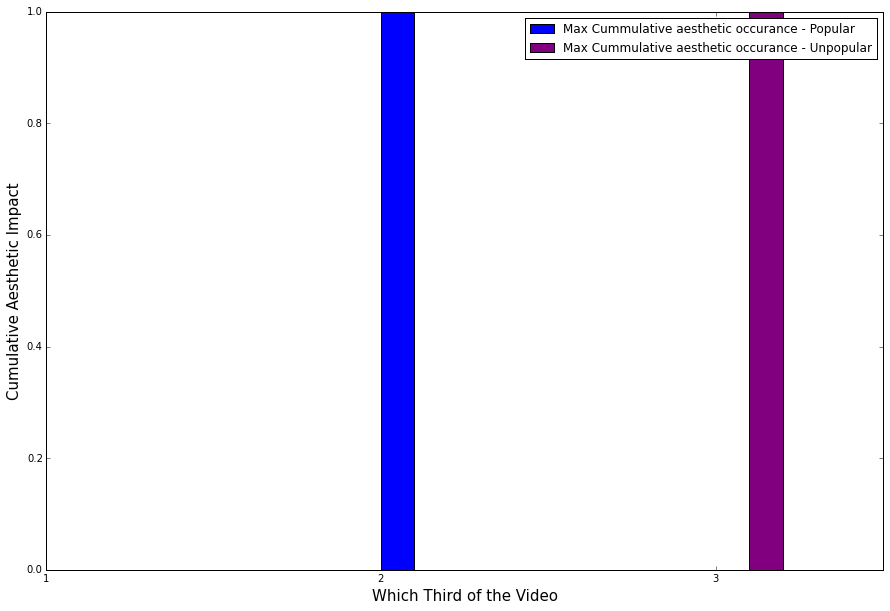

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ind = np.arange(1,4) 
width = 0.1
## the bars
rects1 = ax.bar(ind, maxPopVec, width,
                color='b')
#rects2 = ax.bar(ind+width, minPopVec, width,
#                color='g')
# rects3 = ax.bar(ind+2*width, maxunPopVec, width,
#                 color='r')
rects4 = ax.bar(ind+width, maxunPopVec, width,
                 color='purple')

# add some text for labels, title and axes ticks
ax.set_ylabel('Cumulative Aesthetic Impact',fontsize=15)
ax.set_xlabel('Which Third of the Video',fontsize=15)
plt.legend(['Max Cummulative aesthetic occurance - Popular' , 'Max Cummulative aesthetic occurance - Unpopular' ]
            , loc='upper right')
ax.set_xticks(ind )

plt.show()

In [15]:
pop_features = readFeatureFile(popular_color_features)
unpop_features = readFeatureFile(unpopular_color_features)
aesthetic_features = readFeatureFile(aesthetic_color_features)

50187
21733
1149


In [16]:
popfeatures_matrix , popposts = readFeatures(pop_features)

In [17]:
unpopfeatures_matrix , unpopposts = readFeatures(unpop_features)

In [18]:
aes_feature = readAesFeatuers(aesthetic_features)

In [19]:
print len(popposts) , len(unpopposts)

6751 11723


In [20]:
totalPosts = np.asarray(popposts + unpopposts)
print totalPosts.shape
print totalPosts[1]

(18474,)
1281874693611532288


In [21]:
totalFeats = np.asarray(popfeatures_matrix + unpopfeatures_matrix)
print totalFeats.shape
print totalFeats[15012]

(18474, 19)
[ -1.97269995e-14   4.29733404e+00   4.35666971e-01   2.49023438e-02
   3.80859375e-02   3.13328493e-01   1.90694444e-01   8.86440146e-01
   4.61755756e-02   1.27490974e-01   0.00000000e+00   0.00000000e+00
   1.20529997e-01  -1.28924876e-02   5.53736062e-02   9.59813807e-02
   5.61592882e-01   7.67108616e-02   2.00000000e+00]


In [22]:
totalMap = np.append(totalPosts.reshape((-1,1)),totalFeats , axis=1)
print totalMap[15012]

['1384696746931826688' '-1.97269994996e-14' '4.29733404131'
 '0.435666970725' '0.02490234375' '0.0380859375' '0.313328493495'
 '0.190694444444' '0.886440145673' '0.0461755756228' '0.12749097429' '0.0'
 '0.0' '0.120529996543' '-0.0128924876433' '0.0553736062438'
 '0.0959813807005' '0.561592881944' '0.0767108616108' '2.0']


In [23]:
import pickle
f = open(aesthetic_csv , "w+")
pickle.dump(totalMap, f)
f.close()

In [24]:
f = open(aesthetic_csv , "r+")
feats = pickle.load(f)
f.close()
print feats[104]

['1282183367848497152' '-1.25542623279e-15' '12.0761331195'
 '0.144672389416' '0.001708984375' '0.003173828125' '0.50666930537'
 '0.780613425926' '0.852124605479' '0.0610475900012' '0.18608915614' '0.0'
 '0.0' '0.0056325197426' '-0.453948995118' '0.0118355735306'
 '0.00345532992577' '0.741707175926' '0.00403097359271' '2.0']


In [25]:
unpop_aes_features = np.asarray(unpopfeatures_matrix)
aes_feats = np.asarray(aes_feature)
pop_aes_features = np.asarray(popfeatures_matrix)

print unpop_aes_features.shape , aes_feats.shape , pop_aes_features.shape

(11723, 19) (1149, 19) (6751, 19)


In [26]:
samples_pop = np.random.choice(pop_aes_features.shape[0],1000)
samples_unpop = np.random.choice(unpop_aes_features.shape[0], 1000)
samples_aes = np.random.choice(aes_feats.shape[0], 1000)
sampledpop_aes_features = pop_aes_features[samples_pop,:]
sampledunpop_aes_features = unpop_aes_features[samples_unpop,:]
sampled_aes = aes_feats[samples_aes,:]

In [27]:
print sampledpop_aes_features.shape , sampledunpop_aes_features.shape

(1000, 19) (1000, 19)


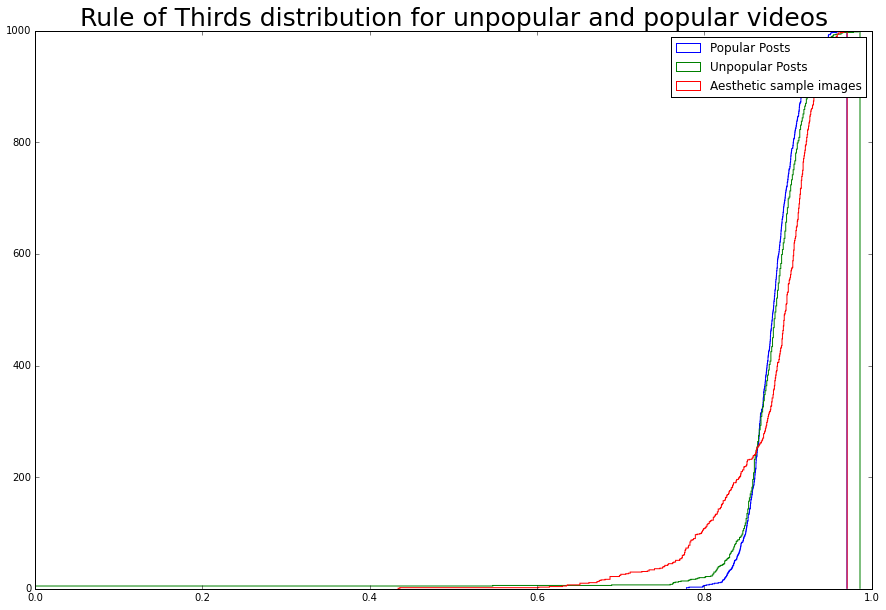

0.882576263496 0.000799974598343
0.879844254531 0.00553009049123
0.879946097424 0.00385360774851


In [28]:
num = 7
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampled_aes[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Rule of Thirds distribution for unpopular and popular videos', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.var(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.var(unpop_aes_features[:,num])
print np.mean(sampled_aes[:,num]) , np.var(sampled_aes[:,num])

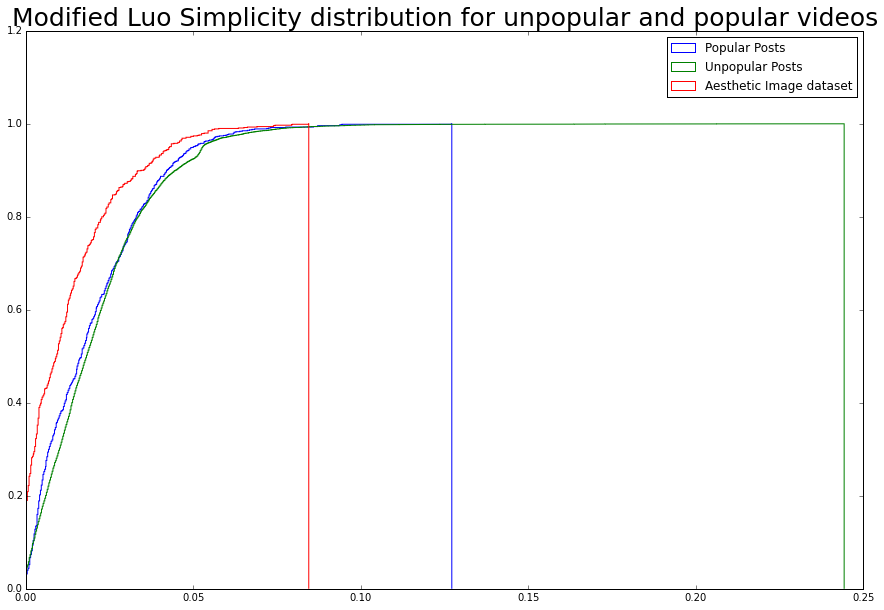

0.0198171386719 0.000286561355531
0.0215392092801 0.00031803318711
0.0130666503906 0.000211532447278


In [29]:
num = 4
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(unpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampled_aes[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic Image dataset'])
plt.title('Modified Luo Simplicity distribution for unpopular and popular videos', fontsize = 25)
plt.show()
print np.mean(sampledpop_aes_features[:,num]) , np.var(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.var(unpop_aes_features[:,num])
print np.mean(sampled_aes[:,num]) , np.var(sampled_aes[:,num])

In [30]:
for i in range(sampledunpop_aes_features.shape[1]):
    print "Index %d" %i
    print "Aesthetic images: %0.3f , %0.3f , %0.3f "%( np.mean(aes_feats[:,i]), np.median(aes_feats[:,i]) , np.var(aes_feats[:,i]) )
    print "Popolar Vines: %0.3f , %0.3f , %0.3f "%( np.mean(sampledpop_aes_features[:,i]), np.median(sampledpop_aes_features[:,i]) , np.var(sampledpop_aes_features[:,i]) )
    print "Unpopular Vines: %0.3f , %0.3f , %0.3f "%( np.mean(sampledunpop_aes_features[:,i]), np.median(sampledunpop_aes_features[:,i]) , np.var(sampledunpop_aes_features[:,i]) )
    print "\n"
                                                                                                  

Index 0
Aesthetic images: 0.000 , -0.000 , 0.000 
Popolar Vines: 0.000 , 0.000 , 0.000 
Unpopular Vines: 0.000 , -0.000 , 0.000 


Index 1
Aesthetic images: 51.049 , 30.228 , 5267.701 
Popolar Vines: 34.200 , 15.570 , 2701.555 
Unpopular Vines: 18.591 , 9.304 , 761.324 


Index 2
Aesthetic images: 0.113 , 0.084 , 0.010 
Popolar Vines: 0.164 , 0.131 , 0.017 
Unpopular Vines: 0.184 , 0.152 , 0.020 


Index 3
Aesthetic images: 0.009 , 0.005 , 0.000 
Popolar Vines: 0.013 , 0.011 , 0.000 
Unpopular Vines: 0.016 , 0.013 , 0.000 


Index 4
Aesthetic images: 0.013 , 0.009 , 0.000 
Popolar Vines: 0.020 , 0.017 , 0.000 
Unpopular Vines: 0.021 , 0.019 , 0.000 


Index 5
Aesthetic images: 0.179 , 0.161 , 0.009 
Popolar Vines: 0.236 , 0.201 , 0.023 
Unpopular Vines: 0.162 , 0.147 , 0.011 


Index 6
Aesthetic images: 0.316 , 0.089 , 0.158 
Popolar Vines: 0.204 , 0.106 , 0.061 
Unpopular Vines: 0.154 , 0.070 , 0.042 


Index 7
Aesthetic images: 0.879 , 0.899 , 0.004 
Popolar Vines: 0.883 , 0.882 , 0.

In [31]:
print entropy(sampledpop_aes_features, sampled_aes, base=None)
print entropy(sampledunpop_aes_features, sampled_aes, base=None)


[        inf  1.31281477  0.6703721   1.01196435         inf  0.36507178
  1.79587223  0.0034289   0.56135257  0.58499254         inf         inf
         inf         inf         inf         inf  0.04845946         inf
         inf]
[        inf  1.20599934  0.68635757  0.90361183         inf  0.3673694
  2.0537962   0.00893239  0.59994766  0.65395752         inf         inf
         inf         inf         inf         inf  0.08220917         inf
         inf]


/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:2491: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:2498: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=0)


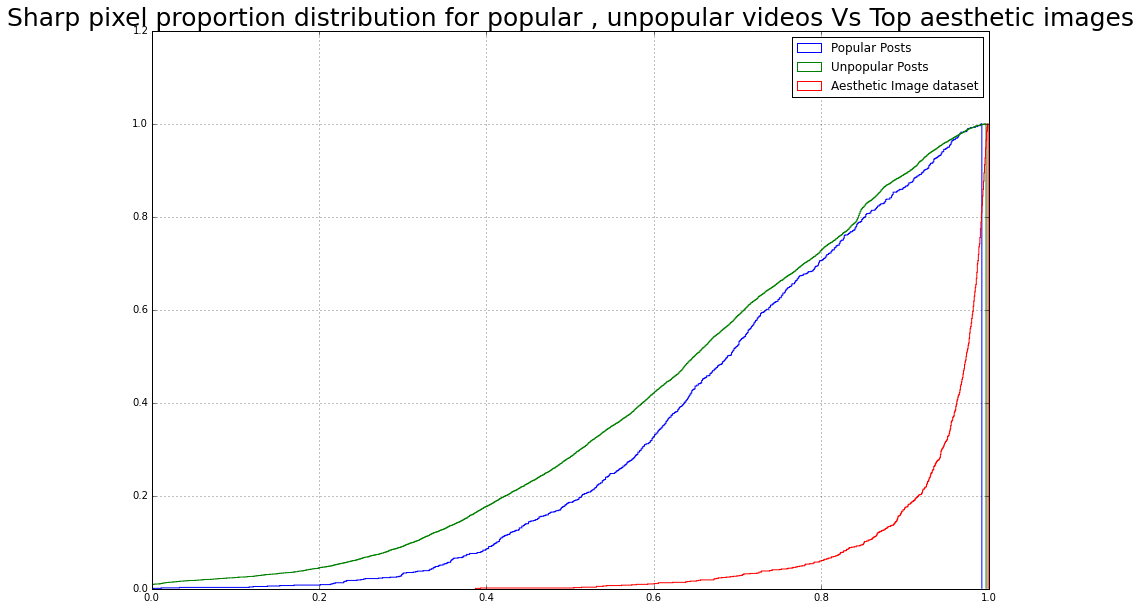

0.675178504533 0.035738849661
0.624999783001 0.0517629736185
0.940863033582 0.00705476316552


In [32]:
num = 16
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0 )
plt.hist(unpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(aes_feats[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' ,'Aesthetic Image dataset'])
plt.title('Sharp pixel proportion distribution for popular , unpopular videos Vs Top aesthetic images', fontsize = 25)
plt.grid()
plt.show()
print np.mean(sampledpop_aes_features[:,num]) , np.var(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.var(unpop_aes_features[:,num])
print np.mean(sampled_aes[:,num]) , np.var(sampled_aes[:,num])

In [33]:
print np.mean(sampledpop_aes_features[:,16]) , np.median(sampledpop_aes_features[:,16])
print np.mean(unpop_aes_features[:,16]) , np.median(unpop_aes_features[:,16])
print np.mean(aes_feats[:,16]) , np.median(aes_feats[:,16])

0.675178504533 0.688804976852
0.624999783001 0.6490234375
0.943023870488 0.973773333333


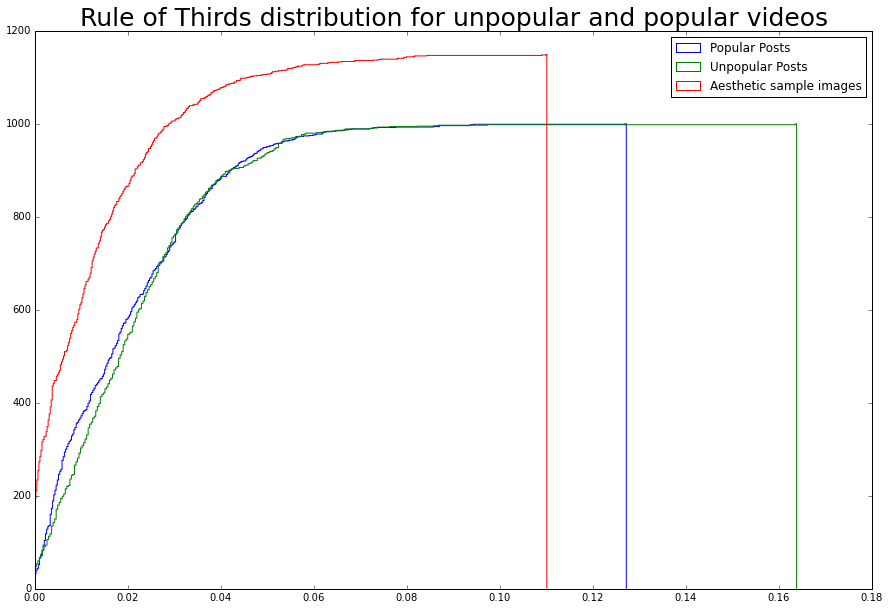

In [34]:
fig, ax = plt.subplots()
num = 4
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 500, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 500, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(aes_feats[:,num], 500, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Rule of Thirds distribution for unpopular and popular videos', fontsize = 25)
plt.show()

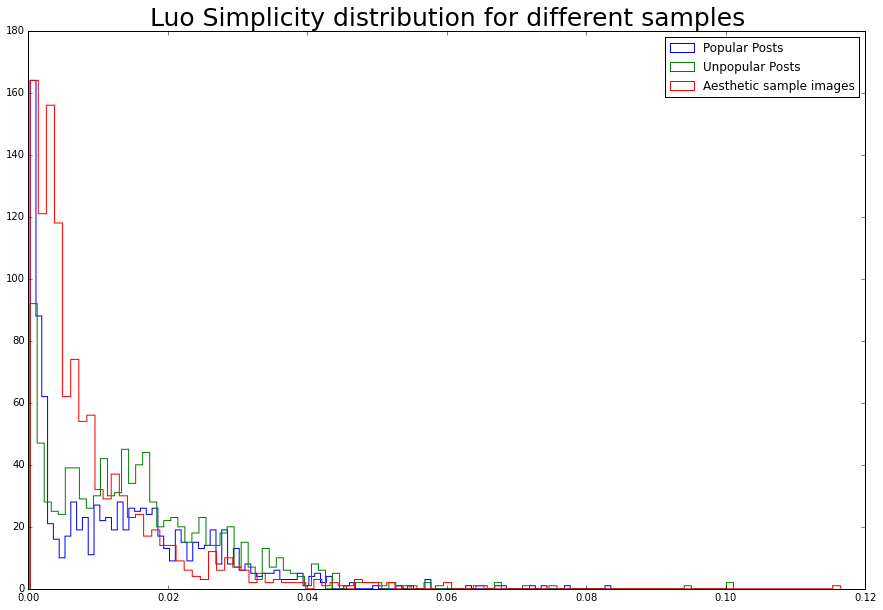

0.0130546875 0.010986328125
0.0156309353474 0.013671875
0.00880691090078 0.005126953125
7.01774738542e-16
8.26921981976e-38


In [35]:
fig, ax = plt.subplots()
num = 3
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(aes_feats[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Luo Simplicity distribution for different samples', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.median(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.median(unpop_aes_features[:,num])
print np.mean(aes_feats[:,num]) , np.median(aes_feats[:,num])
t, p = ttest_ind( sampledpop_aes_features[:,num], sampled_aes[:,num])
print p
t, p = ttest_ind( sampledunpop_aes_features[:,num], sampled_aes[:,num])
print p


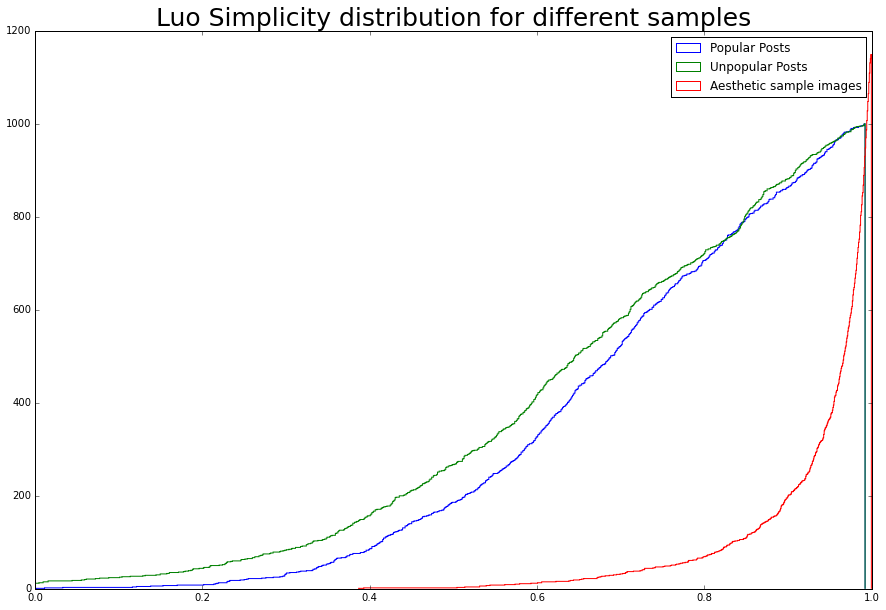

0.675178504533 0.688804976852
0.624999783001 0.6490234375
0.943023870488 0.973773333333


In [36]:
fig, ax = plt.subplots()
num = 16
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(aes_feats[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Luo Simplicity distribution for different samples', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.median(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.median(unpop_aes_features[:,num])
print np.mean(aes_feats[:,num]) , np.median(aes_feats[:,num])